# Regression

## Data pre-processing
First we have to get the data and manipulate it to be able to fit into whichever models we want. 

In [57]:
import pandas as pd

# Get the data
device_uplink = pd.read_csv('device_uplink.csv')

# Mark all NaN cases as zero, they'll get dropped when we create the dummy variables. 
device_uplink.tag_id = device_uplink.tag_id.fillna(value=0)

# Also don't want any negative step counts, since that doesn't make sense. 
device_uplink = device_uplink[device_uplink['step'] >= 0 ]

user_information = pd.read_csv('user_information.csv')

# This is a useful helper function that we will reuse several times later. 
def getRawData():
    return pd.merge(device_uplink, user_information, left_on='owner_id', right_on='user_id', how='inner')

# Only include the data we want to train the models on... 
data = getRawData()
data = data[['tag_id', 'step', 'battery_low', 'depression_score']]

data

,tag_id,step,battery_low,depression_score
0,20.0,4060,36,0.500
1,2.0,10,9,0.500
2,2.0,57,7,0.500
3,2.0,72,5,0.500
4,0.0,89,24,0.500
...,...,...,...,...
289224,12.0,745,50,0.625
289225,0.0,832,48,0.625
289226,0.0,841,47,0.625
289227,2.0,855,47,0.625


In [58]:
# This helper function is another part of the data preprocessing. 
def create_x_y(data):
    x = pd.get_dummies(data['tag_id'], drop_first=True)

    # During forward selection, all column names must be of type 'str'
    x.columns = x.columns.astype(str)

    # On my machine, for some reason it removes all the other columns when I create the dummies,
    # So I have to add them back really quickly. 
    temp = data[['step', 'battery_low']]
    x = pd.concat([x, temp], axis=1, join='outer')

    y = data['depression_score']
    return x, y

x, y = create_x_y(data)

In [59]:
x.head()

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,19.0,20.0,step,battery_low
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4060,36
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,10,9
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,57,7
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,72,5
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,89,24


In [60]:
y.head()

0    0.5
1    0.5
2    0.5
3    0.5
4    0.5
Name: depression_score, dtype: float64

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.4, random_state=1)

# The most basic model you can produce...
model = LinearRegression().fit(train_x, train_y)

Now, we have to assess how the model performs. There's a few metrics we can look at. This is what the book mentions.

In [62]:
print(pd.DataFrame({'Predictor': x.columns, 'coefficient': model.coef_}))

      Predictor  coefficient
0           1.0    -0.032816
1           2.0    -0.007450
2           3.0     0.025046
3           4.0    -0.057082
4           5.0    -0.133114
5           6.0    -0.000682
6           7.0    -0.179468
7           8.0    -0.313941
8           9.0    -0.018188
9          10.0    -0.034575
10         11.0    -0.052573
11         12.0    -0.002442
12         19.0    -0.023099
13         20.0    -0.015467
14         step    -0.000005
15  battery_low    -0.000293


This shows us how the tags influence the depression score. In this case it seems that our most influential predictors are tags `4` and `8`?

Next, let's calculate the score.

In [63]:
print(model.score(valid_x, valid_y))

0.011299708360649086


This is a really low score! What does the regression summary have to say? 

In [64]:
from dmba import regressionSummary
regressionSummary(valid_y, model.predict(valid_x))


Regression statistics

               Mean Error (ME) : 0.0007
Root Mean Squared Error (RMSE) : 0.2840
     Mean Absolute Error (MAE) : 0.2507


I'm not sure why my score is so low if my mean error is low. Shouldn't that normally mean that the score would be *high*?

Anyway, something else to note is the fact that `regressionSummary()` does not return a mean absolute percentage error (MAPE). I checked the GitHub repository containing the source code for this function in `dmba`, which has apparently changed fairly recently. 

Anyway, my attempts to manually calculate the MAPE have resulted in numbers that are not particularly helpful, in that they are incredibly large or small (in degrees of thousands...), so I thought it best to not bother with it so much. 

## Prediction
In order to predict users 495 and 496, we have to create a whole new dataset that excludes them for training.

In [65]:
new_data = getRawData()

# We need these particular users data...
user_495 = new_data.loc[new_data['owner_id'] == 495]
user_496 = new_data.loc[new_data['owner_id'] == 496]

# Now we need the dataset without them in it.
new_data = new_data.drop(new_data.index[new_data['owner_id'].isin([495, 496])])

# Truncate again...
new_data = new_data[['tag_id', 'step', 'battery_low', 'depression_score']]
new_data

,tag_id,step,battery_low,depression_score
0,20.0,4060,36,0.500
1,2.0,10,9,0.500
2,2.0,57,7,0.500
3,2.0,72,5,0.500
4,0.0,89,24,0.500
...,...,...,...,...
289224,12.0,745,50,0.625
289225,0.0,832,48,0.625
289226,0.0,841,47,0.625
289227,2.0,855,47,0.625


As you can see, `new_data` has only 277,430 rows, whereas the original dataset had 289,229— which is a difference of 11,799. 

Additionally, we need to get each user's data. Normally, you could just do:

    user_495 = pd.read_csv('./user_data/data_495.csv')
    user_496 = pd.read_csv('./user_data/data_496.csv')

But this won't work because the information given in the `user_data` folder is actually slightly different from the original `device_uplink.csv`: there are 20 tags in the latter, while only 12 in the former. 

Also, for simplicity's sake, we are going to drop both of these users from the dataset at the same time. If more time were permitted, you could examine the difference in the model's performance when one user is kept and the other is dropped, but I suspect the difference would be minimal. 

Something to note is that some of these users don't end up using some tags at all. What this means is that when I create the `x` and `y` for model training and prediction, the dataframes end up being a few columns smaller. 

To deal with this, I simply decided to add the columns manually and fill them with zeroes.

The columns in the training set are:

    1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 19.0, 20.0, step, battery_low

For user 495, they are:

    1.0, 2.0, 3.0, 6.0, 9.0, 10.0, 11.0, 12.0, 19.0, 20.0, step, battery_low

So that means it's missing `4.0, 5.0, 7.0, 8.0`. 

And for user 496, they are: 

    1.0, 2.0, 3.0, 4.0, 6.0, 9.0, 10.0, 11.0, 12.0, 19.0, 20.0, step, battery_low

So it means that this user is missing `5.0, 7.0, 8.0`, which is one less column than the previous user. 

Now, let's run all the code we ran before and see what the machine thinks the depression scores are.

In [66]:
# Train the model on the data without these users...
x, y = create_x_y(new_data)
train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.4, random_state=1)

# Drop for aforementioned reasons...
train_x = train_x.drop(columns=['4.0', '5.0', '7.0', '8.0'])

model = LinearRegression().fit(train_x, train_y)

In [67]:
# Prediction time!
x, y = create_x_y(user_495)
prediction = model.predict(x)
prediction.shape

(8453,)

Notice that `prediction` is 8,453 rows. Now, it's my understanding that what I have is a prediction of depression score by row. So, it seems acceptable to take the average of all these results to get the predicted depression score, which is shown below.

In [68]:
print(sum(prediction)/len(prediction))

0.3155961577703271


The prediction was `0.3155961577703271`, whereas the real value was `0.25`, with a percent difference of 23%. This seems *acceptably* close. 

In [69]:
# Now for user_496
x, y = create_x_y(user_496)
x = x.drop(columns=['4.0'])
prediction = model.predict(x)
print(sum(prediction)/len(prediction))

0.3114853897359755


For user 496, the prediction was way off. The real value is `0.75` while we predicted `0.3114853897359755`, which is a 82.6% difference— unacceptable.

I suggest that this might be because of the missing columns I had to drop in order to get this whole thing to work. I'm sure there's another approach that can build a model that's more flexible.

Next, we have to look at other regression methods. 

## Forward selection
- Start with no predictors
- Add them one by one (add the one with largest contribution)
- Stop when the addition is not statistically significant

In [70]:
from dmba import AIC_score

# First, let's define some helper functions.
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(train_x[variables], train_y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
       return AIC_score(train_y, [train_y.mean()] * len(train_y), model, df=1)
    return AIC_score(train_y, model.predict(train_x[variables]), model)

In [71]:
from dmba import forward_selection
    
best_model, best_variables = forward_selection(train_x.columns, train_model, score_model,verbose=True)

# Now we need to eavluate how forward selection performs. 
print("\nBest variables: " + str(best_variables))
regressionSummary(valid_y, best_model.predict(valid_x[best_variables]))

Variables: 1.0, 2.0, 3.0, 6.0, 9.0, 10.0, 11.0, 12.0, 19.0, 20.0, step, battery_low
Start: score=56158.77, constant
Step: score=55469.75, add step
Step: score=55137.29, add 10.0
Step: score=55059.77, add 1.0
Step: score=55000.29, add 11.0
Step: score=54983.60, add battery_low
Step: score=54969.26, add 3.0
Step: score=54957.19, add 9.0
Step: score=54955.06, add 12.0
Step: score=54954.50, add 6.0
Step: score=54954.37, add 20.0
Step: score=54954.37, add None

Best variables: ['step', '10.0', '1.0', '11.0', 'battery_low', '3.0', '9.0', '12.0', '6.0', '20.0']

Regression statistics

               Mean Error (ME) : 0.0022
Root Mean Squared Error (RMSE) : 0.2866
     Mean Absolute Error (MAE) : 0.2548


## Backwards Elimination
- Start with all predictors
- Successively eliminate least useful predictors one by one
- Stop when all remaining predictors have statistically significant contribution

In [72]:
from dmba import backward_elimination
allVariables = train_x.columns

best_model, best_variables = backward_elimination(allVariables, train_model, score_model, verbose=True)

# Next, we need to evaluate how backwards elimination performed. 
print("\nBest variables: " + str(best_variables))
regressionSummary(valid_y, best_model.predict(valid_x[best_variables]))

Variables: 1.0, 2.0, 3.0, 6.0, 9.0, 10.0, 11.0, 12.0, 19.0, 20.0, step, battery_low
Start: score=54957.09
Step: score=54955.71, remove 19.0
Step: score=54954.37, remove 2.0
Step: score=54954.37, remove None

Best variables: ['1.0', '3.0', '6.0', '9.0', '10.0', '11.0', '12.0', '20.0', 'step', 'battery_low']

Regression statistics

               Mean Error (ME) : 0.0022
Root Mean Squared Error (RMSE) : 0.2866
     Mean Absolute Error (MAE) : 0.2548


## Stepwise refinement
- Like forward selection	
- Except at each step, also consider dropping non-significant predictors

In [73]:
from dmba import stepwise_selection
best_model, best_variables = stepwise_selection(train_x.columns, train_model, score_model, verbose=True)

# Again, how did it do?
print("\nBest variables: " + str(best_variables))
regressionSummary(valid_y, best_model.predict(valid_x[best_variables]))

Variables: 1.0, 2.0, 3.0, 6.0, 9.0, 10.0, 11.0, 12.0, 19.0, 20.0, step, battery_low
Start: score=56158.77, constant
Step: score=55469.75, add step
Step: score=55137.29, add 10.0
Step: score=55059.77, add 1.0
Step: score=55000.29, add 11.0
Step: score=54983.60, add battery_low
Step: score=54969.26, add 3.0
Step: score=54957.19, add 9.0
Step: score=54955.06, add 12.0
Step: score=54954.50, add 6.0
Step: score=54954.37, add 20.0
Step: score=54954.37, unchanged None

Best variables: ['step', '10.0', '1.0', '11.0', 'battery_low', '3.0', '9.0', '12.0', '6.0', '20.0']

Regression statistics

               Mean Error (ME) : 0.0022
Root Mean Squared Error (RMSE) : 0.2866
     Mean Absolute Error (MAE) : 0.2548


As you can see, all the regression results have the same mean error, and also chose the same best variables:

    ['1.0', '3.0', '9.0', '10.0', '11.0', '12.0', 'step', 'battery_low']

I'm not exactly sure why it ended up like this, but for now I'm just gonna assume that it means that these truly were the best variables to select. 

## Cumulative Lift Chart
The cumulative lift chart shows you the lift factor of how many times it is better to use a model in contrast to not using a model.

- Lift is a measure of the effectiveness of a predictive model calculated as the ratio between the results obtained with and without the predictive model.
- Cumulative gains and lift charts are visual aids for measuring model performance
- Both charts consist of a lift curve and a baseline
- The greater the area between the lift curve and the baseline, the better the model

<AxesSubplot:xlabel='# records', ylabel='# cumulative gains'>

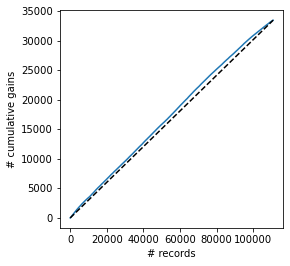

In [74]:
%matplotlib inline
import matplotlib.pylab as plt
from dmba import gainsChart

predProb_valid = best_model.predict(valid_x[best_variables])

df = pd.DataFrame({'actual': valid_y, 'prob': predProb_valid})
df = df.sort_values(by=['prob'], ascending=False).reset_index(drop=True)
fig,ax = plt.subplots()
fig.set_size_inches(4, 4)
gainsChart(df.actual, ax=ax)

Since all my models came out identical, this is what the cumulative lift chart would look like— I think? I may have messed up on the output here... This would apparently mean it doesn't perform much better than randomly selecting stuff, which doesn't line up with the mean error being so low. So something might have gone wrong here.

# Naïve Bayes Classifier

We're still working with the original dataframe, but we need to add `depression_class` and modify it to have categorical variables instead of numerical, since this is a classification problem and not a regression one. 

In [75]:
data = getRawData()

# Eliminate excess or invalid data...
data = data[['tag_id', 'step', 'battery_low', 'depression_class']]
data = data[data['step'] >= 0 ]

# Create dummies
predictors = ['tag_id', 'step', 'battery_low']
x = pd.get_dummies(data[predictors], drop_first=True)

y = data['depression_class'].astype('category')
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.4, random_state=1)

In [76]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB(alpha=0.1)
model.fit(x_train, y_train)

predProb_train = model.predict_proba(x_train)
predProb_valid = model.predict_proba(x_valid)
y_train_pred = model.predict(x_train)
y_valid_pred = model.predict(x_valid)

One of the best metrics for evaluating a classifier's performance is the confusion matrix— my personal favorite. 

Let's see how our model holds up against the validation set.

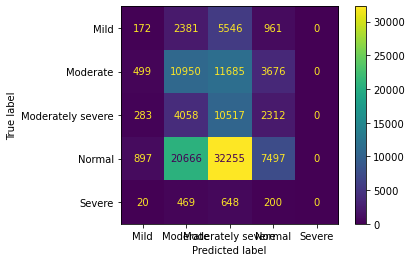

In [77]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

classes = list(y.cat.categories)

cm = confusion_matrix(y_valid, y_valid_pred, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()

Wow... that's... awful! It's so inaccurate and it gets very confused on pretty much everything. 

Also, it apparently never chose to predict anything as "severe". 

So, when I saw this, my first thought was that the model was somehow overfitting to the training set. So let's look at the confusion matrix on the training set and see if it's accuracy is super high or something.

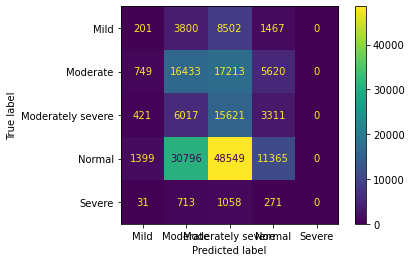

In [78]:
cm = confusion_matrix(y_train, y_train_pred, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()

Nope, it's not a case of overfitting: the accuracy here is really low, too.

Perhaps, then, it's an issue of sampling? I don't see how or why the accuracy should be so low. I went back and tried different `random_state` values to try to get drastically different results, but to no avail. It never solved the problem of the model never predicting 'severe' either.

It's worth mentioning that something else might be wrong here with my dataset. From my analysis, I noticed if you make a dataframe by reading each file in `user_data` individually and appending per file, then you'd end up with slightly different results. So, perhaps there is something there. 

However, by the time I noticed this I was already too far in with this particular dataset, so I had no choice but to move on.

## Conditional probabilities
To find the probability that somebody's depression is moderately severe, we need to look at our dataset. 

From the below code, you can tell the percentage of 'moderately severe' is 18.87%. 

In [79]:
user_information['depression_class'].value_counts()

Normal               25
Moderately severe    10
Moderate              9
Mild                  7
Severe                2
Name: depression_class, dtype: int64

# K-nearest neighbors

## Preprocess data
- Initialize training, validation, and complete data frames

When labelling this data, there were a few things I noticed. 

1. There were an insane amount of tag 0 hits. But this seems to be an invalid tag?
    - To handle this, I marked sections where it was only tag 0 as "None."
2. Most users had nearly all the same tags in use— mainly tag 2 and 10.
3. Some data entries were suspect, for a few reasons:
    - I noticed a few entries where several tags in different locations were all pinged at once. How can someone be in the kitchen, at the front door, and in the bathroom all at the same time?
        - For entries like that, I marked them as "none" since they seemed to contain invalid data, much like tag 0 pings.
    - Some days contained only a very sparse amount of data. It was difficult to annotate this.

When labelling the data, I used some of the criteria for deciding which labels to use.
1. If the steps are low, and it's early in the day, and there is a sudden increase in steps, then the user is probably **waking up**.
2. If the steps are high, and it's very late or early in the day, and the user is not gaining any more steps, then the user is probably **asleep**. 
3. If the user is hitting the kitchen or microwave tag in the same time, or in a huge frequency, then I assume they might be **eating**. Similar thought process applies to the bathroom and toilet tags, where I assume they are going to the bathroom. 
4. If the medicine tag is ever hit, then I assume they're taking their medication. Same for other very low frequency tags, such as "water purifier," which only exists in trace amounts in the entire dataset. 

The total dataset ended up containing 2459 labelled points, which is honestly not too many. I'm certain, too, that I did not do a perfect job of annotating the data, so there are bound to be a few errors in there.

In [80]:
user_506 = pd.read_csv('506.csv')   # user 1
user_516 = pd.read_csv('516.csv')   # user 2
user_655 = pd.read_csv('655.csv')   # user 3, the one we have to predict...

data = pd.concat([user_506, user_516])
data.head()

,start,end,labelName
0,2020-08-12 14:00:00,2020-08-12 14:30:00,Wake up
1,2020-08-12 17:00:00,2020-08-12 17:30:00,Eat
2,2020-08-12 23:00:00,2020-08-12 23:30:00,Sleep
3,2020-08-13 01:00:00,2020-08-13 01:30:00,Sleep
4,2020-08-13 05:00:00,2020-08-13 05:30:00,Sleep


Currently, the data types of all columns is `object`. If we change the first two columns to `datetime64[ns]` then we can use it.

In [81]:
data.start=pd.to_datetime(data.start)
data.end=pd.to_datetime(data.end)

# Also, we have to do the same for user 3...
user_655.start=pd.to_datetime(user_655.start)
user_655.end=pd.to_datetime(user_655.end)

data.dtypes

start        datetime64[ns]
end          datetime64[ns]
labelName            object
dtype: object

User 1 and user 2 are used for training the model and user 3 is used as the validation set to find the best K.

In [82]:
train_x = data.iloc[:, 0:2]
train_y = data.iloc[:, 2:3]
valid_x = user_655.iloc[:, 0:2]
valid_y = user_655.iloc[:, 2:3]

## Training

There is not much data here, actually. However, K-nearest neighbors is good for small datasets. So let's see how different `k` values change the accuracy of the model. 

My hypothesis is that a lower `k` is better for the model, since the labels change quite quickly from neighbor to neighbor. 

In [83]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

results = []
for k in range(1, 15):
    # We do train_y.values.ravel() to avoid warnings.
    knn = KNeighborsClassifier(n_neighbors=k).fit(train_x, train_y.values.ravel())
    results.append({
        'k': k,
        'accuracy': accuracy_score(valid_y, knn.predict(valid_x))
    })

results = pd.DataFrame(results)
results

,k,accuracy
0,1,0.273983
1,2,0.228924
2,3,0.218750
3,4,0.223110
4,5,0.248547
5,6,0.252180
6,7,0.257994
7,8,0.254360
8,9,0.247093
9,10,0.249273


Let's see a graph of the results.

<AxesSubplot:xlabel='k', ylabel='accuracy'>

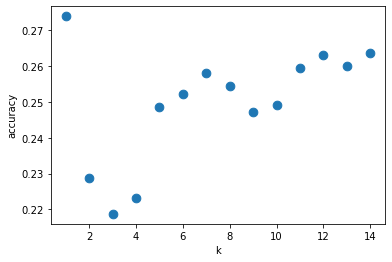

In [84]:
results.plot.scatter(s=75, y='accuracy', x='k')

So, it appears that our best classifier is with `k=1`. As soon as `k` increments, it's accuracy drops (relative to other entries) significantly. Then it begins climbing again. 

As `k` approaches `n` (size of set), it theoretically should approach the accuracy achieved by a Naive Bayes classifier. But, as you can see `k=1` performs better than `k=14`, even if marginally. There could be an issue of overfitting here.  